# 4 | FigS1F Detected vs Undetected Proteins

This notebook documents the analysis of RNA-seq expression of detected versus undetected proteins, shown in Fig S1F. 

##### Import packages

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
from matplotlib.patches import Patch
import matplotlib.backends.backend_pdf
from matplotlib.patches import Patch
import fastcluster
from adjustText import adjust_text
import matplotlib.font_manager

In [40]:
import matplotlib.font_manager
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'Arial'

##### Import datasets

In [8]:
df = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_working_matrix_averaged.txt', sep='\t').set_index('Project_Identifier')
df_frozen = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_frozen_matrix_averaged.txt', sep='\t').set_index('Project_Identifier')
df_sample_map = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_sample_mapping_replicates.txt', sep='\t').set_index('Automatic_MS_filename')
df_sample_map['Tissue_type'] = df_sample_map['Tissue_type'].str.replace('Haematopoietic','Hematopoietic')
df_map = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_sample_mapping_averaged.txt', sep='\t').set_index('Project_Identifier')
df_map['Tissue_type'] = df_map['Tissue_type'].str.replace('Haematopoietic','Hematopoietic')
print('Protein matrix shape:',df.shape)
print('Frozen protein matrix shape:',df_frozen.shape)
print('Master mapping file shape:', df_sample_map.shape)
print('Mapping file shape:',df_map.shape)

Protein matrix shape: (949, 6692)
Frozen protein matrix shape: (949, 8498)
Master mapping file shape: (6864, 12)
Mapping file shape: (949, 5)


In [9]:
prot_gene_df = pd.read_csv('matrix_diann_normalised_051021/uniprot-yourlist_M20211011A084FC58F6BBA219896F365D15F2EB442254481.tab', sep='\t')
print('Proteins in mapping:',len(prot_gene_df))
prot_gene_df = prot_gene_df.rename(columns={'Gene names  (primary )':'Gene'}).dropna()[lambda x: x['Entry name'].str.contains('_HUMAN')]
prot_gene_df['ID'] = prot_gene_df['Entry']+';'+prot_gene_df['Entry name']
prot_gene_dict = prot_gene_df.set_index('ID').to_dict()['Gene']
gene_prot_dict = prot_gene_df.set_index('Gene').to_dict()['ID']

Proteins in mapping: 8498


##### Get median proteins per cell line

In [10]:
print('Median proteins per cell line:',str(df_frozen.count(axis=1).median()))
print('Minimum proteins per cell line:',str(df_frozen.count(axis=1).min()))
print('Maximum proteins per cell line:',str(df_frozen.count(axis=1).max()))

Median proteins per cell line: 5237.0
Minimum proteins per cell line: 2523
Maximum proteins per cell line: 6251


##### Compare RNA abundance of observed vs missing proteins

MannwhitneyuResult(statistic=14987485.5, pvalue=0.0)


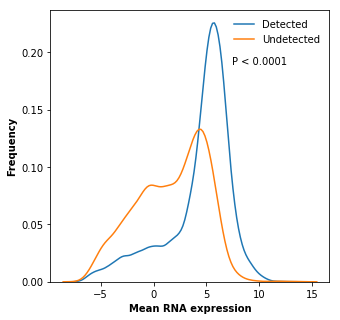

In [35]:
# Import RNA-seq data
df_rna = pd.read_csv('../files_e0022_cell_lines_diann_reanalysis/rnaseq_voom.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
df_rna = df_rna[[x for x in df_rna.columns.tolist() if x in df_map['SIDM'].unique().tolist()]]
df_rna = df_rna.rename(columns=df_map.reset_index().set_index('SIDM').to_dict()['Project_Identifier'])

# Define detected and undetected genes
detected_genes = [x for x in df_rna.index.tolist() if x in list(gene_prot_dict.keys())]
undetected_genes =[x for x in df_rna.index.tolist() if x not in list(gene_prot_dict.keys())]

# Compare means
detected_genes_mean = df_rna.loc[detected_genes].mean(axis=1)
undetected_genes_mean = df_rna.loc[undetected_genes].mean(axis=1)
print(scipy.stats.mannwhitneyu(undetected_genes_mean, detected_genes_mean))

# Generate plot
fig = plt.figure(figsize=[5,5])
plot = sns.distplot(detected_genes_mean, label='Detected', hist=False)
plot = sns.distplot(undetected_genes_mean, label='Undetected', hist=False)
plot.set_xlabel('Mean RNA expression', weight='bold')
plot.set_ylabel('Frequency', weight='bold')
plot.text(0.65,0.8, 'P < 0.0001', transform = plot.transAxes)
plt.legend(frameon=False)
plt.savefig('Revisions/distribution_mean_rna_exp.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/distribution_mean_rna_exp.png', dpi=500, bbox_inches='tight')
plt.show()